In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark
import pprint
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV
from functools import reduce
from pyspark.sql.functions import col

from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

import pickle

In [2]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

25/06/25 16:56:57 WARN Utils: Your hostname, Baohongs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.169.0.196 instead (on interface en0)
25/06/25 16:56:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/25 16:56:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
model_train_date_str = "2018-04-01" # "2018-04-1"
train_test_period_months = 12
oot_period_months = 1
train_test_ratio = 0.2

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")


# OOT periods (3 consecutive months before model_train_date)
config["oot3_end_date"] = config['model_train_date'] - timedelta(days=1)
config["oot3_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)
config["oot2_end_date"] = config['oot3_start_date'] - timedelta(days=1)
config["oot2_start_date"] = config['oot3_start_date'] - relativedelta(months=oot_period_months)
config["oot1_end_date"] = config['oot2_start_date'] - timedelta(days=1)
config["oot1_start_date"] = config['oot2_start_date'] - relativedelta(months=oot_period_months) 

config["train_test_end_date"] = config["oot1_start_date"] - timedelta(days=1)
config["train_test_start_date"] = config["oot1_start_date"] - relativedelta(months=train_test_period_months)
config["train_test_ratio"] = train_test_ratio

#config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
#config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
#config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
#config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
#config["train_test_ratio"] = train_test_ratio 

pprint.pprint(config)

{'model_train_date': datetime.datetime(2018, 4, 1, 0, 0),
 'model_train_date_str': '2018-04-01',
 'oot1_end_date': datetime.datetime(2018, 1, 31, 0, 0),
 'oot1_start_date': datetime.datetime(2018, 1, 1, 0, 0),
 'oot2_end_date': datetime.datetime(2018, 2, 28, 0, 0),
 'oot2_start_date': datetime.datetime(2018, 2, 1, 0, 0),
 'oot3_end_date': datetime.datetime(2018, 3, 31, 0, 0),
 'oot3_start_date': datetime.datetime(2018, 3, 1, 0, 0),
 'oot_period_months': 1,
 'train_test_end_date': datetime.datetime(2017, 12, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.2,
 'train_test_start_date': datetime.datetime(2017, 1, 1, 0, 0)}


## get data 

In [4]:
def read_gold_table(table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df


In [34]:
features_store_sdf = read_gold_table('feature_store', 'datamart/gold', spark)
label_store_sdf = read_gold_table('label_store', 'datamart/gold', spark)

## Data split

In [35]:
#Filter for delivered data for training 
features_store_sdf = features_store_sdf.drop("avg_delay_rate","concentration","act_days_to_deliver","total_freight_value","avg_processing_time","same_state","total_volume_cm3")
rows_with_nulls = features_store_sdf.filter(
    reduce(lambda a, b: a | b, (col(c).isNull() for c in features_store_sdf.columns)))
order_ids_to_drop = [row["order_id"] for row in rows_with_nulls.select("order_id").distinct().collect()]

features_store_sdf = features_store_sdf.filter(~col("order_id").isin(order_ids_to_drop))
features_store_sdf = features_store_sdf.filter(col("order_status") == "delivered")

In [36]:
#Filter for test and train data
label_store_sdf = label_store_sdf.filter(~col("order_id").isin(order_ids_to_drop))
y_model = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["train_test_end_date"]))
y_model_oot1 = label_store_sdf.filter((col("snapshot_date") >= config["oot1_start_date"]) & (col("snapshot_date") <= config["oot1_end_date"]))
y_model_oot2 = label_store_sdf.filter((col("snapshot_date") >= config["oot2_start_date"]) & (col("snapshot_date") <= config["oot2_end_date"]))
y_model_oot3 = label_store_sdf.filter((col("snapshot_date") >= config["oot3_start_date"]) & (col("snapshot_date") <= config["oot3_end_date"]))


# Change to pandas for training 
features_store_sdf = features_store_sdf.toPandas().sort_values(by=["order_id"])
y_model = y_model.toPandas().sort_values(by=["order_id"]).drop_duplicates(subset="order_id")
order_ids = y_model["order_id"].unique()
X_model = features_store_sdf[features_store_sdf["order_id"].isin(order_ids)].drop_duplicates(subset="order_id")

# Change to pandas for OOT 
y_model_oot1 = y_model_oot1.toPandas().sort_values(by=["order_id"])
order_ids_1 = y_model_oot1["order_id"].unique()
X_model_oot1 = features_store_sdf[features_store_sdf["order_id"].isin(order_ids_1)].drop_duplicates(subset="order_id")

y_model_oot2 = y_model_oot2.toPandas().sort_values(by=["order_id"])
order_ids_2 = y_model_oot2["order_id"].unique()
X_model_oot2 = features_store_sdf[features_store_sdf["order_id"].isin(order_ids_2)].drop_duplicates(subset="order_id")

y_model_oot3 = y_model_oot3.toPandas().sort_values(by=["order_id"])
order_ids_3 = y_model_oot3["order_id"].unique()
X_model_oot3 = features_store_sdf[features_store_sdf["order_id"].isin(order_ids_3)].drop_duplicates(subset="order_id")

print("Extract data for training and testing...")
print("extracted labels_sdf", y_model.shape[0])
print("extracted features_sdf", X_model.shape[0])

print("\n Extract data for oot...")
print("extracted labels_sdf", y_model_oot1.shape[0])
print("extracted features_sdf", X_model_oot1.shape[0])
print("extracted labels_sdf", y_model_oot2.shape[0])
print("extracted features_sdf", X_model_oot2.shape[0])
print("extracted labels_sdf", y_model_oot3.shape[0])
print("extracted features_sdf", X_model_oot3.shape[0])

Extract data for training and testing...
extracted labels_sdf 41788
extracted features_sdf 41788

 Extract data for oot...
extracted labels_sdf 6845
extracted features_sdf 6845
extracted labels_sdf 6411
extracted features_sdf 6411
extracted labels_sdf 6957
extracted features_sdf 6957


In [37]:
y_model['order_id'].nunique()

41788

In [38]:
# 1. Count of each season
season_counts = features_store_sdf['season'].value_counts().sort_index()

# 2. Percentage of each season
season_percentage = round((season_counts / season_counts.sum()) * 100, 2)

season_percentage

season
Autumn    13.35
Spring    12.18
Summer    65.97
Winter     8.49
Name: count, dtype: float64

In [39]:
print(X_model.shape)
print(X_model_oot1.shape)
print(X_model_oot2.shape)
print(X_model_oot3.shape)

print(y_model.shape)
print(y_model_oot1.shape)
print(y_model_oot2.shape)
print(y_model_oot3.shape)

(41788, 15)
(6845, 15)
(6411, 15)
(6957, 15)
(41788, 3)
(6845, 3)
(6411, 3)
(6957, 3)


## Prepare data for training

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, 
                                                    test_size=config['train_test_ratio'], 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=y_model['miss_delivery_sla'])

In [41]:
print(X_train.shape)
print(X_test.shape)
print(X_model_oot1.shape)
print(X_model_oot2.shape)
print(X_model_oot3.shape)


X_model_oot1['season']


(33430, 15)
(8358, 15)
(6845, 15)
(6411, 15)
(6957, 15)


92161     Summer
72384     Summer
92162     Summer
72385     Summer
71512     Summer
           ...  
83541     Summer
86228     Summer
100322    Summer
84281     Summer
85263     Summer
Name: season, Length: 6845, dtype: object

In [42]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Fit on X_train with one season dropped
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['season']])  # Only fit on training data

# 2. Transform train
encoded_train = encoder.transform(X_train[['season']])
encoded_df_train = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(['season']), index=X_train.index)
X_train = pd.concat([X_train.drop(columns=['season']), encoded_df_train], axis=1)

# 3. Transform test
encoded_test = encoder.transform(X_test[['season']])
encoded_df_test = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(['season']), index=X_test.index)
X_test = pd.concat([X_test.drop(columns=['season']), encoded_df_test], axis=1)

# 4. Transform OOT
encoded_oot1 = encoder.transform(X_model_oot1[['season']])
encoded_df_oot1 = pd.DataFrame(encoded_oot1, columns=encoder.get_feature_names_out(['season']), index=X_model_oot1.index)
X_model_oot1 = pd.concat([X_model_oot1.drop(columns=['season']), encoded_df_oot1], axis=1)

encoded_oot2 = encoder.transform(X_model_oot2[['season']])
encoded_df_oot2 = pd.DataFrame(encoded_oot2, columns=encoder.get_feature_names_out(['season']), index=X_model_oot2.index)
X_model_oot2 = pd.concat([X_model_oot2.drop(columns=['season']), encoded_df_oot2], axis=1)

encoded_oot3 = encoder.transform(X_model_oot3[['season']])
encoded_df_oot3 = pd.DataFrame(encoded_oot3, columns=encoder.get_feature_names_out(['season']), index=X_model_oot3.index)
X_model_oot3 = pd.concat([X_model_oot3.drop(columns=['season']), encoded_df_oot3], axis=1)

In [43]:
print(X_train.shape)
print(X_test.shape)
print(X_model_oot1.shape)
print(X_model_oot2.shape)
print(X_model_oot3.shape)

(33430, 17)
(8358, 17)
(6845, 17)
(6411, 17)
(6957, 17)


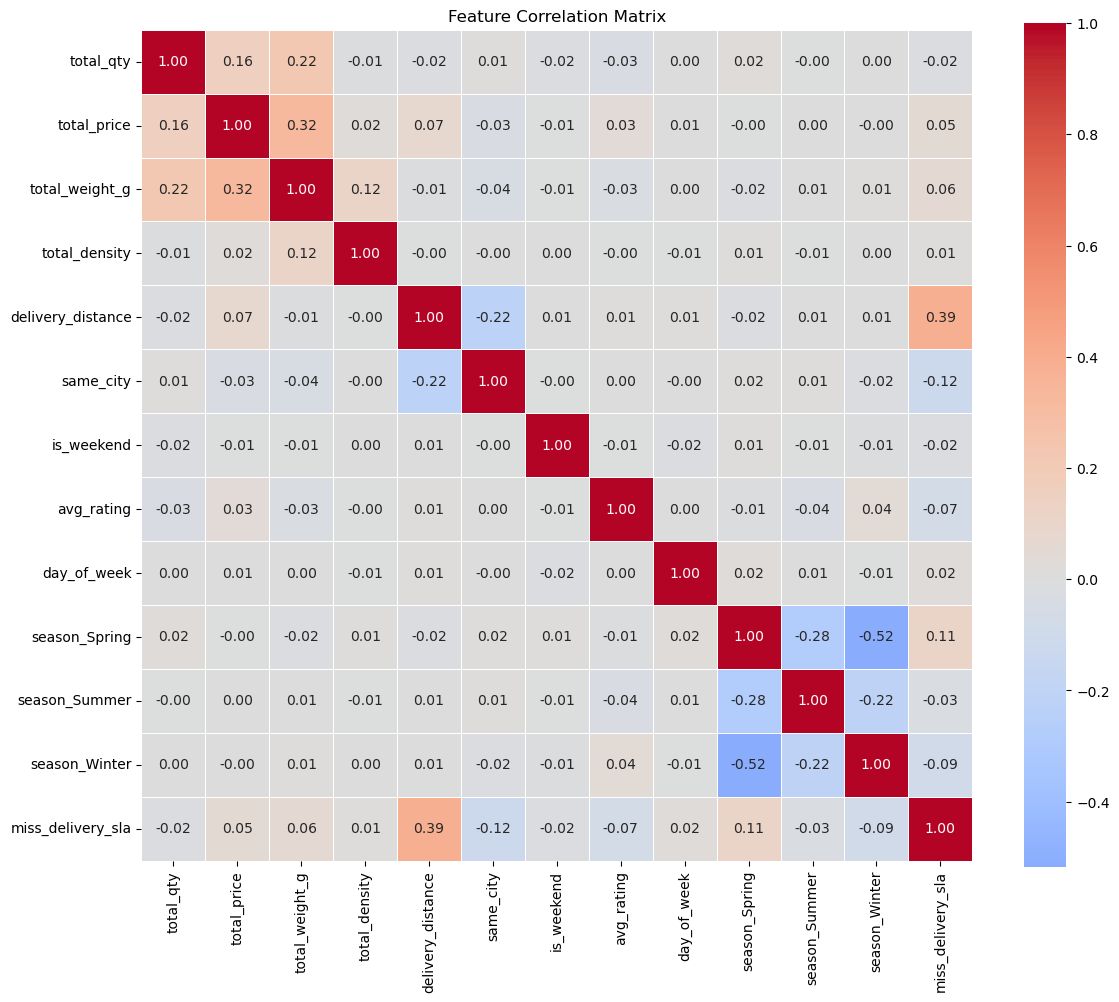

In [44]:
Xy_merged = X_train.merge(y_model, on='order_id', how='left')

Xy_merged

numeric = Xy_merged.select_dtypes(include='number')
numeric.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric.corr(),
    annot=True,       # Show correlation values
    fmt=".2f",         # Format to 2 decimal places
    cmap="coolwarm",   # Color gradient: red to blue
    center=0,          # Center color at 0 correlation
    square=True,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [45]:
# Transform data into numpy arrays
X_train_arr = X_train.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date']).values
X_test_arr = X_test.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date']).values
X_oot_arr1 = X_model_oot1.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date']).values
X_oot_arr2 = X_model_oot2.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date']).values
X_oot_arr3 = X_model_oot3.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date']).values

y_train = y_train['miss_delivery_sla'].values
y_test = y_test['miss_delivery_sla'].values
y_oot1 = y_model_oot1['miss_delivery_sla'].values
y_oot2 = y_model_oot2['miss_delivery_sla'].values
y_oot3 = y_model_oot3['miss_delivery_sla'].values

# Normalize the data using sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
transformer_stdscaler = scaler.fit(X_train_arr)

X_train_processed = transformer_stdscaler.transform(X_train_arr)
X_test_processed = transformer_stdscaler.transform(X_test_arr)
X_oot_processed1 = transformer_stdscaler.transform(X_oot_arr1)
X_oot_processed2 = transformer_stdscaler.transform(X_oot_arr2)
X_oot_processed3 = transformer_stdscaler.transform(X_oot_arr3)


# Print diagnostics
print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed1', X_oot_processed1.shape[0])
print('X_oot_processed2', X_oot_processed2.shape[0])
print('X_oot_processed3', X_oot_processed3.shape[0])
print("X_train shape:", X_train_arr.shape)

X_train_processed 33430
X_test_processed 8358
X_oot_processed1 6845
X_oot_processed2 6411
X_oot_processed3 6957
X_train shape: (33430, 12)


In [46]:
transformer_stdscaler.n_features_in_ 

12

In [96]:
X_features = X_train.drop(columns=['order_id','order_status','seller_city','seller_state','snapshot_date'])

X_features.columns

Index(['total_qty', 'total_price', 'total_weight_g', 'total_density',
       'delivery_distance', 'same_city', 'is_weekend', 'avg_rating',
       'day_of_week', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

## Train the model

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Define fixed hyperparameters
params = {
    'n_estimators': 300,
    'max_depth': 3,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'min_child_weight': 3,
    'reg_alpha': 3,
    'reg_lambda': 1
}

# Train model
model = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    **params
)

model.fit(X_train_processed, y_train)

# Predict and evaluate
y_pred_train = model.predict_proba(X_train_processed)[:, 1]
y_pred_test = model.predict_proba(X_test_processed)[:, 1]
y_pred_oot1 = model.predict_proba(X_oot_processed1)[:, 1]
y_pred_oot2 = model.predict_proba(X_oot_processed2)[:, 1]
y_pred_oot3 = model.predict_proba(X_oot_processed3)[:, 1]

train_auc = roc_auc_score(y_train, y_pred_train)
test_auc = roc_auc_score(y_test, y_pred_test)
oot_auc1 = roc_auc_score(y_oot1, y_pred_oot1)
oot_auc2 = roc_auc_score(y_oot2, y_pred_oot2)
oot_auc3 = roc_auc_score(y_oot3, y_pred_oot3)

print("\n=== MODEL EVALUATION ===")
print("Train AUC:", round(train_auc, 4), "| GINI:", round(2*train_auc - 1, 4))
print("Test AUC :", round(test_auc, 4), "| GINI:", round(2*test_auc - 1, 4))
print("OOT AUC 1 :", round(oot_auc1, 4), "| GINI:", round(2*oot_auc1 - 1, 4))
print("OOT AUC 2 :", round(oot_auc2, 4), "| GINI:", round(2*oot_auc2 - 1, 4))
print("OOT AUC 3 :", round(oot_auc3, 4), "| GINI:", round(2*oot_auc3 - 1, 4))


=== MODEL EVALUATION ===
Train AUC: 0.7682 | GINI: 0.5364
Test AUC : 0.7669 | GINI: 0.5338
OOT AUC 1 : 0.7557 | GINI: 0.5114
OOT AUC 2 : 0.7842 | GINI: 0.5683
OOT AUC 3 : 0.7779 | GINI: 0.5557


In [66]:
df_results = pd.DataFrame({
    'modelname': ['xgb'],
    'metrics': ['AUC'],
    'Train': [train_auc],
    'Test': [test_auc],
    'OOT 1': [oot_auc1],
    'OOT 2': [oot_auc2],
    'OOT 3': [oot_auc3]
})

df_results

,modelname,metrics,Train,Test,OOT 1,OOT 2,OOT 3
0,xgb,AUC,0.768212,0.766894,0.755701,0.784174,0.777855


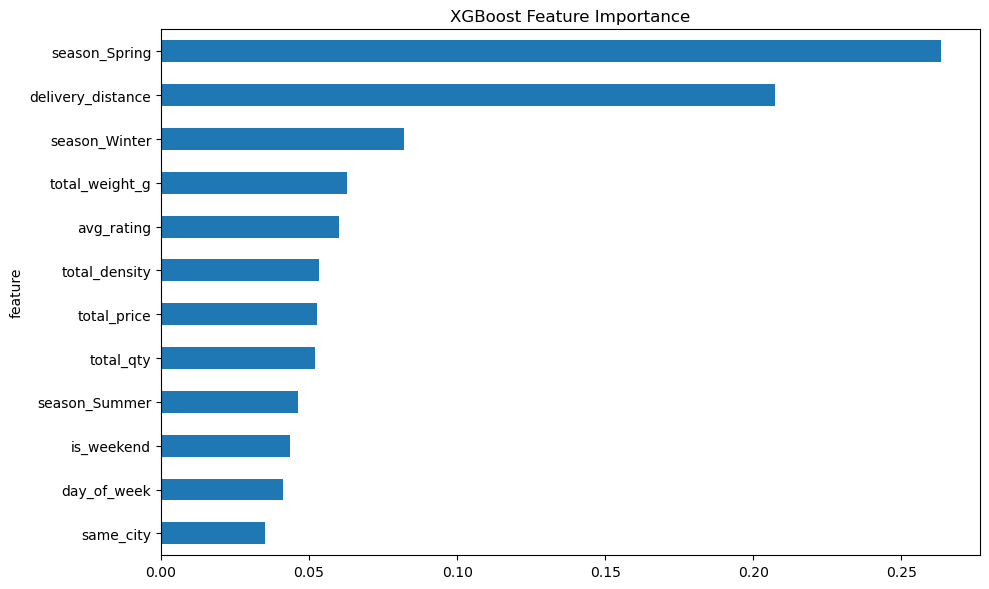

In [67]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# After training
model = XGBClassifier()
model.fit(X_train_processed, y_train)

# Get importance as a dictionary
importances = model.feature_importances_

# Create a DataFrame for easy visualization
import pandas as pd
feat_importance_df = pd.DataFrame({
    'feature': X_features.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
feat_importance_df.plot(kind='barh', x='feature', y='importance', figsize=(10, 6), legend=False)
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

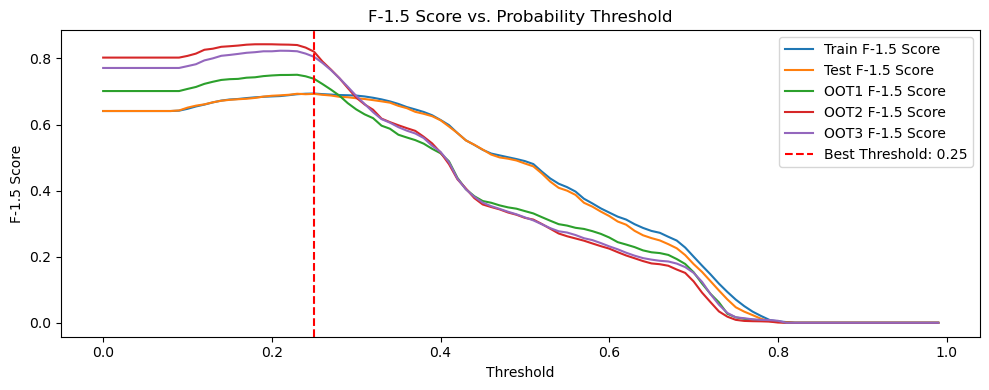

In [68]:
# F1.5 score across thresholds - recall is more important
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train, y_pred_train > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test, y_pred_test > t, beta=beta) for t in thresholds]
f1_scores_oot1 = [fbeta_score(y_oot1, y_pred_oot1 > t, beta=beta) for t in thresholds]
f1_scores_oot2 = [fbeta_score(y_oot2, y_pred_oot2 > t, beta=beta) for t in thresholds]
f1_scores_oot3 = [fbeta_score(y_oot3, y_pred_oot3 > t, beta=beta) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores_train)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label="Train F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_test, label="Test F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_oot1, label="OOT1 F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_oot2, label="OOT2 F-%.1f Score" % beta)
plt.plot(thresholds, f1_scores_oot3, label="OOT3 F-%.1f Score" % beta)
plt.axvline(x=best_threshold, color="red", linestyle="--", label="Best Threshold: %.2f" % round(best_threshold, 2))
plt.title("F-%.1f Score vs. Probability Threshold" % beta)
plt.xlabel("Threshold")
plt.ylabel("F-%.1f Score" % beta)
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

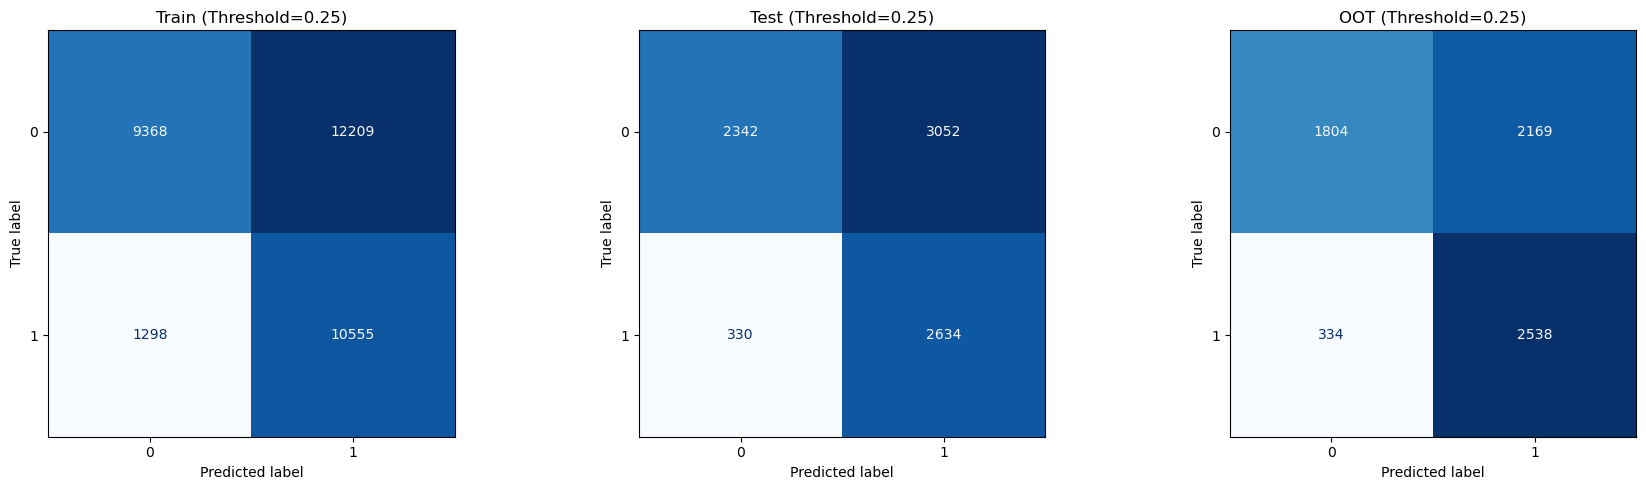

In [69]:
# Predictions
y_pred_train = (y_pred_train > best_threshold).astype(int)
y_pred_test = (y_pred_test > best_threshold).astype(int)
y_pred_oot1 = (y_pred_oot1 > best_threshold).astype(int)
y_pred_oot2 = (y_pred_oot2 > best_threshold).astype(int)
y_pred_oot3 = (y_pred_oot3 > best_threshold).astype(int)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
cm_oot1 = confusion_matrix(y_oot1, y_pred_oot1)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Train
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axs[0], cmap='Blues', colorbar=False)
axs[0].set_title(f"Train (Threshold={best_threshold:.2f})")
axs[0].grid(False)

# Test
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axs[1], cmap='Blues', colorbar=False)
axs[1].set_title(f"Test (Threshold={best_threshold:.2f})")
axs[1].grid(False)

# OOT
disp_oot = ConfusionMatrixDisplay(confusion_matrix=cm_oot1)
disp_oot.plot(ax=axs[2], cmap='Blues', colorbar=False)
axs[2].set_title(f"OOT (Threshold={best_threshold:.2f})")
axs[2].grid(False)

plt.tight_layout()
plt.show()

In [70]:
# Set beta
beta = 1.5

# Compute F1.5 scores
f1_5_train = fbeta_score(y_train, y_pred_train, beta=beta)
f1_5_test = fbeta_score(y_test, y_pred_test, beta=beta)
f1_5_oot1 = fbeta_score(y_oot1, y_pred_oot1, beta=beta)
f1_5_oot2 = fbeta_score(y_oot2, y_pred_oot2, beta=beta)
f1_5_oot3 = fbeta_score(y_oot3, y_pred_oot3, beta=beta)

# Print results
print("\n=== MODEL F1.5 SCORE ===")
print(f"Train F1.5 Score : {f1_5_train:.4f}")
print(f"Test F1.5 Score  : {f1_5_test:.4f}")
print(f"OOT 1 F1.5 Score   : {f1_5_oot1:.4f}")
print(f"OOT 2 F1.5 Score   : {f1_5_oot2:.4f}")
print(f"OOT 3 F1.5 Score   : {f1_5_oot3:.4f}")


=== MODEL F1.5 SCORE ===
Train F1.5 Score : 0.6939
Test F1.5 Score  : 0.6929
OOT 1 F1.5 Score   : 0.7385
OOT 2 F1.5 Score   : 0.8206
OOT 3 F1.5 Score   : 0.8051


In [71]:
df_new = pd.DataFrame({
    'modelname': ['xgb'],
    'metrics': ['F1-5'],
    'Train': [f1_5_train],
    'Test': [f1_5_test],
    'OOT 1': [f1_5_oot1],
    'OOT 2': [f1_5_oot2],
    'OOT 3': [f1_5_oot3]
})

# Concatenate vertically
df_results = pd.concat([df_results, df_new], ignore_index=True)

In [72]:
df_results

,modelname,metrics,Train,Test,OOT 1,OOT 2,OOT 3
0,xgb,AUC,0.768212,0.766894,0.755701,0.784174,0.777855
1,xgb,F1-5,0.693941,0.692877,0.738517,0.820590,0.805101


#### Logistic regression

In [73]:
# Train model
clf = LogisticRegression()
clf.fit(X_train_processed, y_train)

# Predict and evaluate
y_pred_proba_train = clf.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_proba_train)

y_pred_proba_test = clf.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_proba_test)

y_pred_proba_oot1 = clf.predict_proba(X_oot_processed1)[:, 1]
oot_auc1 = roc_auc_score(y_oot1, y_pred_proba_oot1)

y_pred_proba_oot2 = clf.predict_proba(X_oot_processed2)[:, 1]
oot_auc1 = roc_auc_score(y_oot2, y_pred_proba_oot2)

y_pred_proba_oot3 = clf.predict_proba(X_oot_processed3)[:, 1]
oot_auc1 = roc_auc_score(y_oot3, y_pred_proba_oot3)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"OOT 1 AUC: {oot_auc1:.4f}")
print(f"OOT 2 AUC: {oot_auc2:.4f}")
print(f"OOT 3 AUC: {oot_auc3:.4f}")

df_new = pd.DataFrame({
    'modelname': ['reg'],
    'metrics': ['AUC'],
    'Train': [train_auc],
    'Test': [test_auc],
    'OOT 1': [oot_auc1],
    'OOT 2': [oot_auc2],
    'OOT 3': [oot_auc3]
})

# Concatenate vertically
df_results = pd.concat([df_results, df_new], ignore_index=True)

Train AUC: 0.7555
Test AUC: 0.7603
OOT 1 AUC: 0.7738
OOT 2 AUC: 0.7842
OOT 3 AUC: 0.7779


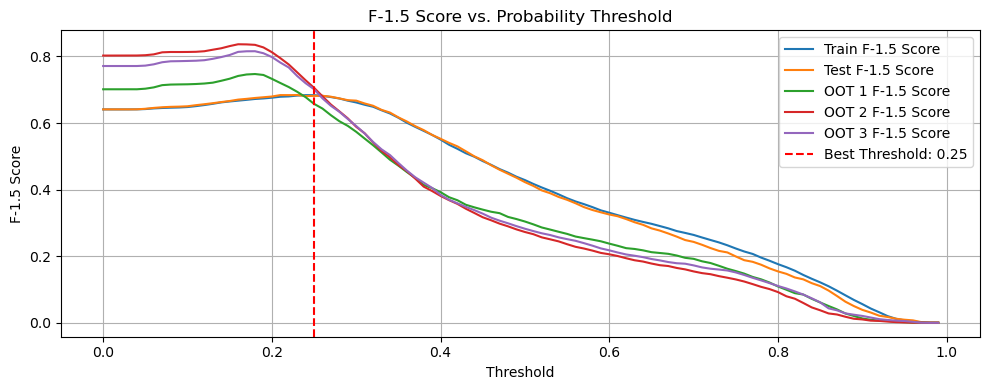

In [74]:
# F2 score across thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
beta = 1.5
f1_scores_train = [fbeta_score(y_train, y_pred_proba_train > t, beta=beta) for t in thresholds]
f1_scores_test = [fbeta_score(y_test, y_pred_proba_test > t, beta=beta) for t in thresholds]
f1_scores_oot1 = [fbeta_score(y_oot1, y_pred_proba_oot1 > t, beta=beta) for t in thresholds]
f1_scores_oot2 = [fbeta_score(y_oot2, y_pred_proba_oot2 > t, beta=beta) for t in thresholds]
f1_scores_oot3 = [fbeta_score(y_oot3, y_pred_proba_oot3 > t, beta=beta) for t in thresholds]
best_threshold_reg = thresholds[np.argmax(f1_scores_train)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores_train, label=f"Train F-{beta} Score")
plt.plot(thresholds, f1_scores_test, label=f"Test F-{beta} Score")
plt.plot(thresholds, f1_scores_oot1, label=f"OOT 1 F-{beta} Score")
plt.plot(thresholds, f1_scores_oot2, label=f"OOT 2 F-{beta} Score")
plt.plot(thresholds, f1_scores_oot3, label=f"OOT 3 F-{beta} Score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.title(f"F-{beta} Score vs. Probability Threshold")
plt.xlabel("Threshold")
plt.ylabel(f"F-{beta} Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
print(f"Best Train F{beta}-Score: {max(f1_scores_train):.4f}")
print(f"Best Test F{beta}-Score: {max(f1_scores_test):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot1):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot2):.4f}")
print(f"Best OOT F{beta}-Score: {max(f1_scores_oot3):.4f}")

df_new = pd.DataFrame({
    'modelname': ['reg'],
    'metrics': ['F1-5'],
    'Train': [max(f1_scores_train)],
    'Test': [max(f1_scores_test)],
    'OOT 1': [max(f1_scores_oot1)],
    'OOT 2': [max(f1_scores_oot2)],
    'OOT 3': [max(f1_scores_oot3)]
})

# Concatenate vertically
df_results = pd.concat([df_results, df_new], ignore_index=True)

Best Train F1.5-Score: 0.6838
Best Test F1.5-Score: 0.6841
Best OOT F1.5-Score: 0.7473
Best OOT F1.5-Score: 0.8367
Best OOT F1.5-Score: 0.8157


In [77]:
df_results

,modelname,metrics,Train,Test,OOT 1,OOT 2,OOT 3
0,xgb,AUC,0.768212,0.766894,0.755701,0.784174,0.777855
1,xgb,F1-5,0.693941,0.692877,0.738517,0.820590,0.805101
2,reg,AUC,0.755528,0.760296,0.773802,0.784174,0.777855
3,reg,F1-5,0.683830,0.684101,0.747258,0.836655,0.815737


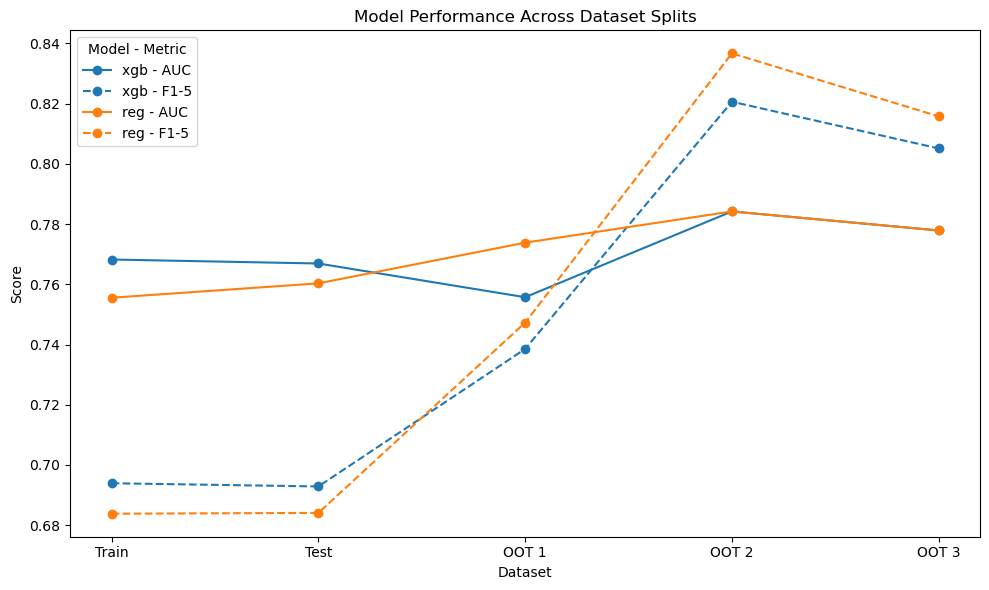

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset labels for x-axis
x_labels = ['Train', 'Test', 'OOT 1', 'OOT 2', 'OOT 3']
plt.figure(figsize=(10, 6))

# Assign one color per model
model_colors = {
    'xgb': 'tab:blue',
    'reg': 'tab:orange'
}

for idx, row in df_results.iterrows():
    y_values = row[x_labels].values
    model = row['modelname']
    metric = row['metrics']
    
    label = f"{model} - {metric}"  # Show both model and metric
    linestyle = '-' if metric == 'AUC' else '--'
    color = model_colors[model]    # Color by model
    
    plt.plot(x_labels, y_values, marker='o', linestyle=linestyle, color=color, label=label)

plt.title('Model Performance Across Dataset Splits')
plt.xlabel('Dataset')
plt.ylabel('Score')
plt.legend(title="Model - Metric")
#plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
model_artefact_reg = {}

model_artefact_reg['model'] = clf
model_artefact_reg['hp_params'] = clf.get_params()
model_artefact_reg['model_version'] = "reg_"+config["model_train_date_str"].replace('-','_')
model_artefact_reg['preprocessing_transformers'] = {}
model_artefact_reg['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact_reg['data_dates'] = config
model_artefact_reg['data_stats'] = {}
model_artefact_reg['data_stats']['X_train'] = X_train_arr.shape[0]
model_artefact_reg['data_stats']['X_test'] = X_test_arr.shape[0]
model_artefact_reg['data_stats']['X_oot1'] = X_oot_arr1.shape[0]
model_artefact_reg['data_stats']['X_oot2'] = X_oot_arr2.shape[0]
model_artefact_reg['data_stats']['X_oot3'] = X_oot_arr3.shape[0]
model_artefact_reg['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact_reg['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact_reg['data_stats']['y_oot1'] = round(y_oot1.mean(),2)
model_artefact_reg['data_stats']['y_oot2'] = round(y_oot2.mean(),2)
model_artefact_reg['data_stats']['y_oot3'] = round(y_oot3.mean(),2)
model_artefact_reg['results'] = {}
model_artefact_reg['results']['f1_train'] = max(f1_scores_train)
model_artefact_reg['results']['f1_test'] =  max(f1_scores_test)
model_artefact_reg['results']['f1_oot1'] =  max(f1_scores_oot1)
model_artefact_reg['results']['f1_oot2'] =  max(f1_scores_oot2)
model_artefact_reg['results']['f1_oot3'] =  max(f1_scores_oot3)
model_artefact_reg['threshold'] = best_threshold_reg

pprint.pprint(model_artefact_reg)

{'data_dates': {'model_train_date': datetime.datetime(2018, 4, 1, 0, 0),
                'model_train_date_str': '2018-04-01',
                'oot1_end_date': datetime.datetime(2018, 1, 31, 0, 0),
                'oot1_start_date': datetime.datetime(2018, 1, 1, 0, 0),
                'oot2_end_date': datetime.datetime(2018, 2, 28, 0, 0),
                'oot2_start_date': datetime.datetime(2018, 2, 1, 0, 0),
                'oot3_end_date': datetime.datetime(2018, 3, 31, 0, 0),
                'oot3_start_date': datetime.datetime(2018, 3, 1, 0, 0),
                'oot_period_months': 1,
                'train_test_end_date': datetime.datetime(2017, 12, 31, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.2,
                'train_test_start_date': datetime.datetime(2017, 1, 1, 0, 0)},
 'data_stats': {'X_oot1': 6845,
                'X_oot2': 6411,
                'X_oot3': 6957,
                'X_test': 8358,
                'X_train': 334

## prepare model artefact to save

In [88]:
model_artefact_xgb = {}

model_artefact_xgb['model'] = model
model_artefact_xgb['hp_params'] = params
model_artefact_xgb['model_version'] = "xgb_"+config["model_train_date_str"].replace('-','_')
model_artefact_xgb['preprocessing_transformers'] = {}
model_artefact_xgb['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact_xgb['data_dates'] = config
model_artefact_xgb['data_stats'] = {}
model_artefact_xgb['data_stats']['X_train'] = X_train_arr.shape[0]
model_artefact_xgb['data_stats']['X_test'] = X_test_arr.shape[0]
model_artefact_xgb['data_stats']['X_oot1'] = X_oot_arr1.shape[0]
model_artefact_xgb['data_stats']['X_oot2'] = X_oot_arr2.shape[0]
model_artefact_xgb['data_stats']['X_oot3'] = X_oot_arr3.shape[0]
model_artefact_xgb['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact_xgb['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact_xgb['data_stats']['y_oot'] = round(y_oot1.mean(),2)
model_artefact_xgb['data_stats']['y_oot'] = round(y_oot2.mean(),2)
model_artefact_xgb['data_stats']['y_oot'] = round(y_oot3.mean(),2)
model_artefact_xgb['results'] = {}
model_artefact_xgb['results']['auc_train'] = train_auc
model_artefact_xgb['results']['auc_test'] = test_auc
model_artefact_xgb['results']['auc_oot1'] = oot_auc1
model_artefact_xgb['results']['auc_oot2'] = oot_auc2
model_artefact_xgb['results']['auc_oot3'] = oot_auc3
model_artefact_xgb['results']['gini_train'] = round(2*train_auc-1,3)
model_artefact_xgb['results']['gini_test'] = round(2*test_auc-1,3)
model_artefact_xgb['results']['gini_oot'] = round(2*oot_auc1-1,3)
model_artefact_xgb['results']['gini_oot'] = round(2*oot_auc2-1,3)
model_artefact_xgb['results']['gini_oot'] = round(2*oot_auc3-1,3)
model_artefact_xgb['results']['f1_train'] = f1_5_train
model_artefact_xgb['results']['f1_test'] = f1_5_test
model_artefact_xgb['results']['f1_oot'] = f1_5_oot1
model_artefact_xgb['results']['f1_oot'] = f1_5_oot2
model_artefact_xgb['results']['f1_oot'] = f1_5_oot3
model_artefact_xgb['threshold'] = best_threshold

pprint.pprint(model_artefact_xgb)

{'data_dates': {'model_train_date': datetime.datetime(2018, 4, 1, 0, 0),
                'model_train_date_str': '2018-04-01',
                'oot1_end_date': datetime.datetime(2018, 1, 31, 0, 0),
                'oot1_start_date': datetime.datetime(2018, 1, 1, 0, 0),
                'oot2_end_date': datetime.datetime(2018, 2, 28, 0, 0),
                'oot2_start_date': datetime.datetime(2018, 2, 1, 0, 0),
                'oot3_end_date': datetime.datetime(2018, 3, 31, 0, 0),
                'oot3_start_date': datetime.datetime(2018, 3, 1, 0, 0),
                'oot_period_months': 1,
                'train_test_end_date': datetime.datetime(2017, 12, 31, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.2,
                'train_test_start_date': datetime.datetime(2017, 1, 1, 0, 0)},
 'data_stats': {'X_oot1': 6845,
                'X_oot2': 6411,
                'X_oot3': 6957,
                'X_test': 8358,
                'X_train': 334

## save artefact to model bank

In [89]:
import os
os.getcwd()

'/Users/baohongzhuang/Desktop/03 MLE/MLE_grp10/scripts'

In [90]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [91]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact_reg['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact_reg, file)

print(f"Model saved to {file_path}")

Model saved to model_bank/reg_2018_04_01.pkl


In [92]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact_xgb['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact_xgb, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/xgb_2018_04_01.pkl


## test load pickle and make model inference

In [95]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed1)[:, 1]
oot_auc_score = roc_auc_score(y_oot1, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

AttributeError: 'str' object has no attribute 'predict_proba'